In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import random

In [9]:
class DataGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames, image_folder, mask_folder, batch_size=1, img_size=(256, 256)):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.indexes = np.arange(len(self.image_filenames))
    
    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.image_filenames[k] for k in indexes]
        batch_masks = [self.mask_filenames[k] for k in indexes]
        images, masks = self.__load_batch(batch_images, batch_masks)
        return images, masks
    
    def __load_batch(self, batch_images, batch_masks):
        images = []
        masks = []
        for img_file, mask_file in zip(batch_images, batch_masks):
            img = load_img(os.path.join(self.image_folder, img_file), target_size=self.img_size)
            img = img_to_array(img) / 255.0
            mask = load_img(os.path.join(self.mask_folder, mask_file), target_size=self.img_size, color_mode='grayscale')
            mask = img_to_array(mask) / 255.0
            images.append(img)
            masks.append(mask)
        return np.array(images), np.array(masks)

In [10]:
dataset_path = "/kaggle/input/flood-dataset/flood detection dataset"
image_folder =  f"{dataset_path}/Image"
mask_folder = f"{dataset_path}/Mask"
if os.path.exists(image_folder) and os.path.exists(mask_folder):
    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

In [ ]:
from sklearn.model_selection import train_test_split

train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.33, random_state=42 
)

train_generator = DataGenerator(train_images, train_masks, image_folder, mask_folder, batch_size=1)
val_generator = DataGenerator(val_images, val_masks, image_folder, mask_folder, batch_size=1)
test_generator = DataGenerator(test_images, test_masks, image_folder, mask_folder, batch_size=1)

print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")

Training set: 231 images
Validation set: 38 images
Test set: 20 images


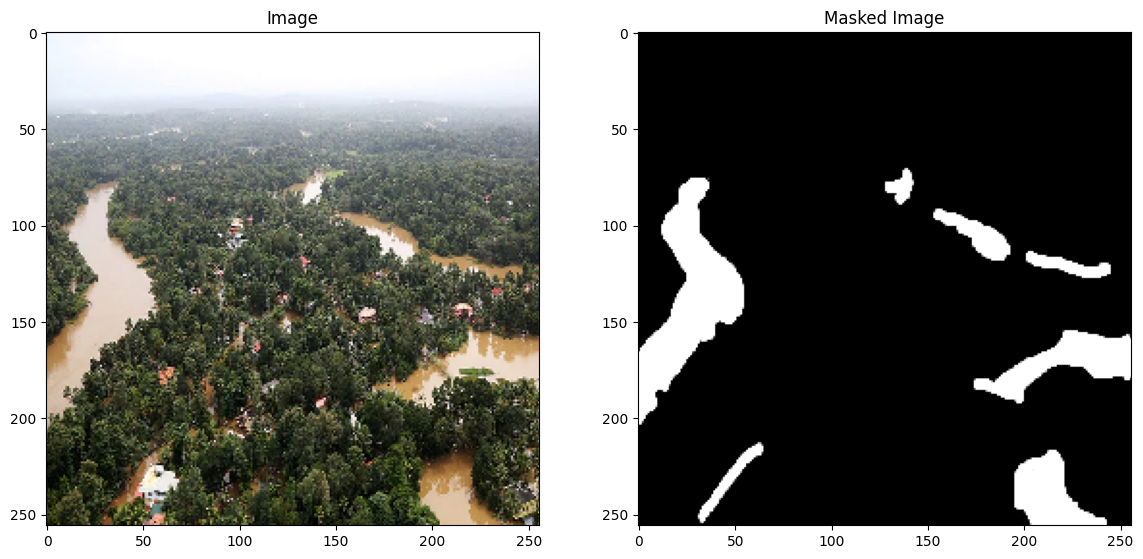

In [ ]:

random_image_id = random.randint(0, len(train_generator) - 1)
sample_image, sample_mask = train_generator[random_image_id]

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(sample_image[0]) 
plt.title("Image")

plt.subplot(122)
plt.imshow(sample_mask[0].squeeze(), cmap='gray')  
plt.title("Masked Image")
plt.show()

In [ ]:
from tensorflow.keras.layers import Lambda

import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.layers import Input, Embedding, Concatenate, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model

class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]
        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x


def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(num_heads=cf["num_heads"], key_dim=cf["hidden_dim"])(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Add()([x, skip_2])

    return x


def extract_patches(inputs, patch_size):
    return tf.image.extract_patches(
        inputs, sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding="VALID"
    )

def ViT_Segmentation(cf):

    input_shape = (cf["image_size"], cf["image_size"], cf["num_channels"])
    inputs = Input(input_shape)

    num_patches = (cf["image_size"] // cf["patch_size"]) ** 2
    flattened_patch_dim = cf["patch_size"] * cf["patch_size"] * cf["num_channels"]

    patches = Lambda(lambda x: extract_patches(x, cf["patch_size"]))(inputs)
    patches = Reshape((num_patches, flattened_patch_dim))(patches)
    patch_embed = Dense(cf["hidden_dim"])(patches) 

    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = Embedding(input_dim=num_patches, output_dim=cf["hidden_dim"])(positions)
    embed = patch_embed + pos_embed

    x = embed
    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    x = Reshape((cf["image_size"] // cf["patch_size"], cf["image_size"] // cf["patch_size"], cf["hidden_dim"]))(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    outputs = Conv2DTranspose(cf["num_classes"], (1, 1), activation="sigmoid")(x)

    model = Model(inputs, outputs)
    return model

In [14]:
cf = {
    "image_size": 256,  
    "patch_size": 16,  
    "num_channels": 3,  
    "hidden_dim": 768,  
    "mlp_dim": 3072,  
    "num_heads": 12,  
    "num_layers": 6,
    "dropout_rate": 0.1,
    "num_classes": 1  
}
model = ViT_Segmentation(cf)

In [15]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU, Precision, Recall

mIoU = MeanIoU(num_classes=2)
precision = Precision()
recall = Recall()

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_score = 2 * (p * r) / (p + r + K.epsilon())
    return f1_score

def mean_iou(y_true, y_pred):
    return mIoU(y_true, y_pred)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0  
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred)

In [16]:


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
              loss=combined_loss,  
              metrics=["accuracy",dice_coefficient, f1_score, mean_iou, precision, recall])

In [17]:
model_history=model.fit(train_generator, validation_data=val_generator, epochs=100)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


231/231 ━━━━━━━━━━━━━━━━━━━━ 78s 171ms/step - accuracy: 0.5587 - dice_coefficient: 0.4175 - f1_score: 0.3891 - loss: 0.6354 - mean_iou: 0.3121 - precision_1: 0.4495 - recall_1: 0.3887 - val_accuracy: 0.5037 - val_dice_coefficient: 0.4642 - val_f1_score: 0.6049 - val_loss: 0.6175 - val_mean_iou: 0.2982 - val_precision_1: 0.4711 - val_recall_1: 0.8013
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - accuracy: 0.5133 - dice_coefficient: 0.4459 - f1_score: 0.5767 - loss: 0.6287 - mean_iou: 0.2960 - precision_1: 0.4576 - recall_1: 0.6290 - val_accuracy: 0.5489 - val_dice_coefficient: 0.4494 - val_f1_score: 0.5156 - val_loss: 0.6182 - val_mean_iou: 0.2746 - val_precision_1: 0.4984 - val_recall_1: 0.5268
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 150ms/step - accuracy: 0.5690 - dice_coefficient: 0.4389 - f1_score: 0.4956 - loss: 0.6197 - mean_iou: 0.2595 - precision_1: 0.4879 - recall_1: 0.5679 - val_accuracy: 0.7134 - val_dice_coefficient: 0.5680 - val_f1_score: 0.7500 - val_loss:

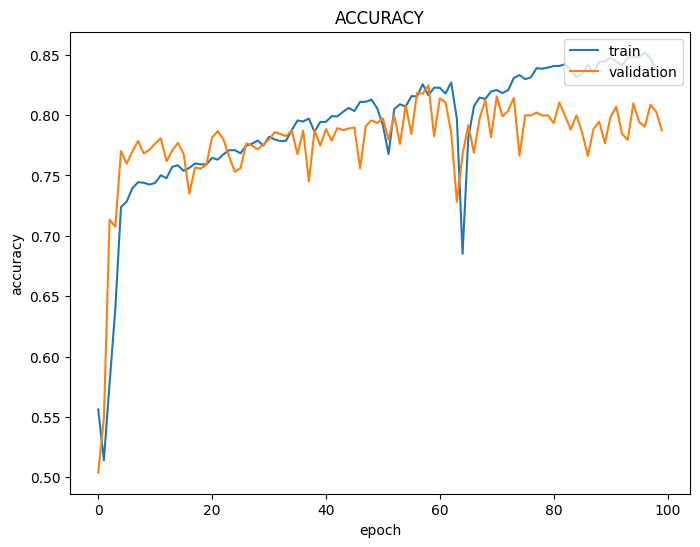

In [18]:
fig,ax11=plt.subplots(figsize=(8,6))
ax11.plot(model_history.history['accuracy'])
ax11.plot(model_history.history['val_accuracy'])
ax11.title.set_text('ACCURACY')
ax11.set_ylabel('accuracy')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper right')

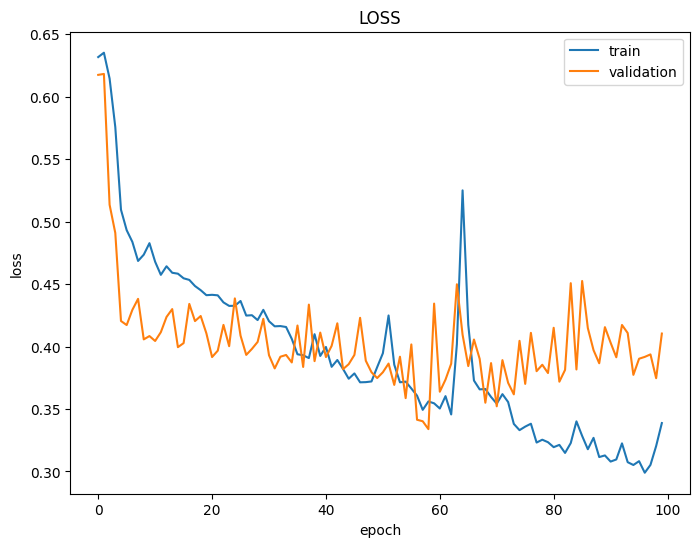

In [19]:
fig,ax12 = plt.subplots(figsize=(8,6))
ax12.plot(model_history.history['loss'])
ax12.plot(model_history.history['val_loss'])
ax12.title.set_text('LOSS')
ax12.set_ylabel('loss')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper right')

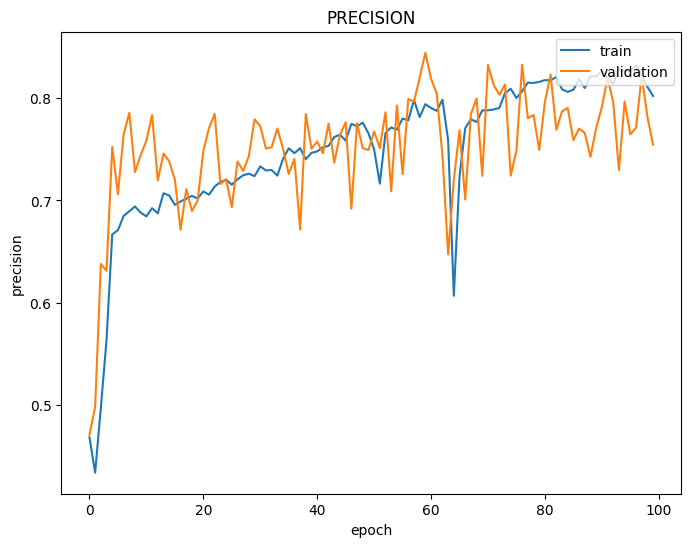

In [21]:
fig,ax13=plt.subplots(figsize=(8,6))
ax13.plot(model_history.history['precision_1'])
ax13.plot(model_history.history['val_precision_1'])
ax13.title.set_text('PRECISION')
ax13.set_ylabel('precision')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper right')

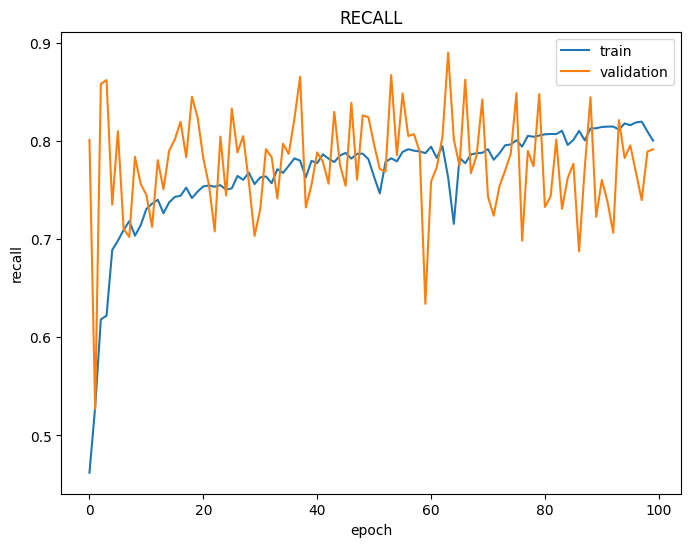

In [22]:
fig,ax14=plt.subplots(figsize=(8,6))
ax14.plot(model_history.history['recall_1'])
ax14.plot(model_history.history['val_recall_1'])
ax14.title.set_text('RECALL')
ax14.set_ylabel('recall')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper right')

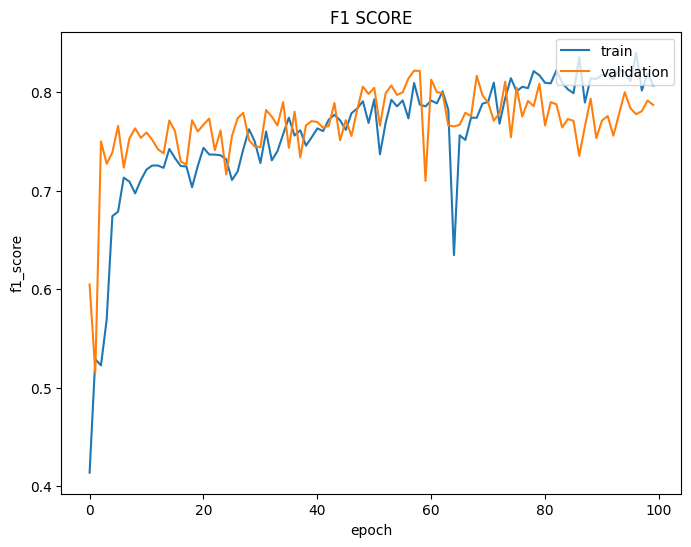

In [23]:
fig,ax15=plt.subplots(figsize=(8,6))
ax15.plot(model_history.history['f1_score'])
ax15.plot(model_history.history['val_f1_score'])
ax15.title.set_text('F1 SCORE')
ax15.set_ylabel('f1_score')
ax15.set_xlabel('epoch')
ax15.legend(['train', 'validation'], loc='upper right')

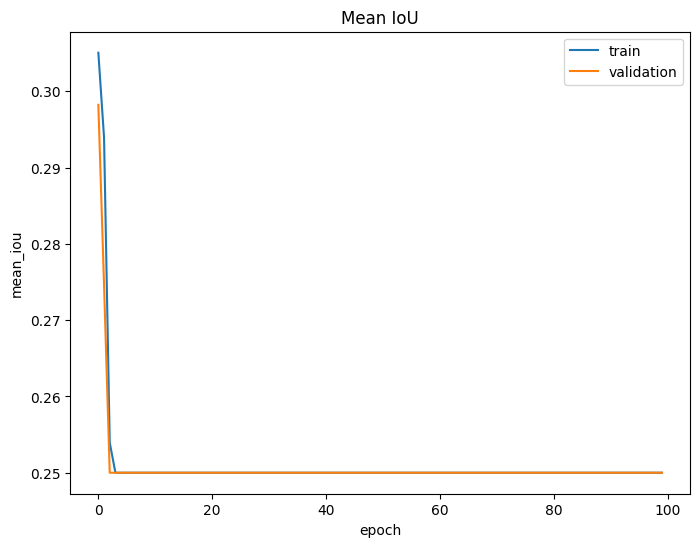

In [24]:
fig,ax16=plt.subplots(figsize=(8,6))
ax16.plot(model_history.history['mean_iou'])
ax16.plot(model_history.history['val_mean_iou'])
ax16.title.set_text('Mean IoU')
ax16.set_ylabel('mean_iou')
ax16.set_xlabel('epoch')
ax16.legend(['train', 'validation'], loc='upper right')

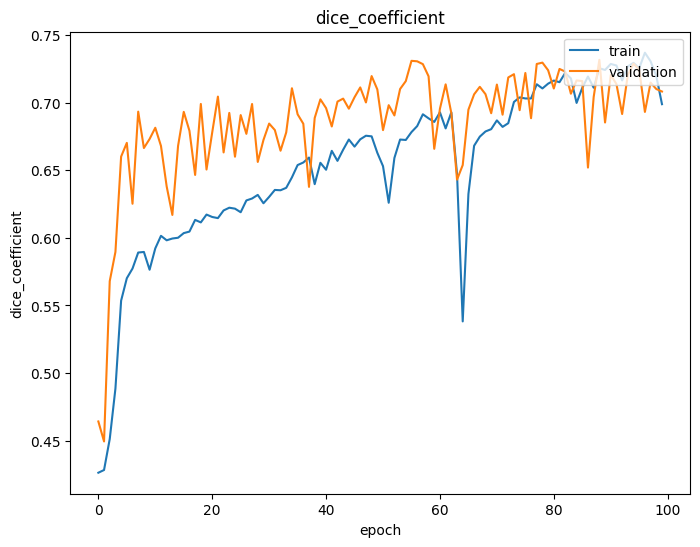

In [25]:
fig,ax17=plt.subplots(figsize=(8,6))
ax17.plot(model_history.history['dice_coefficient'])
ax17.plot(model_history.history['val_dice_coefficient'])
ax17.title.set_text('dice_coefficient')
ax17.set_ylabel('dice_coefficient')
ax17.set_xlabel('epoch')
ax17.legend(['train', 'validation'], loc='upper right')

In [26]:
pred_masks = model.predict(test_generator)
pred_masks = (pred_masks > 0.5).astype(np.uint8)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


In [27]:
loss,dice_coefficient, accuracy, f1_score, precision, recall,mean_iou = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"dice coefficient: {dice_coefficient:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test MeanIoU: {mean_iou:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7770 - dice_coefficient: 0.6718 - f1_score: 0.7751 - loss: 0.4054 - mean_iou: 0.2500 - precision_1: 0.7386 - recall_1: 0.7869
Test Loss: 0.4214
dice coefficient: 0.7883
Test Accuracy: 0.6335
Test F1 Score: 0.7609
Test Precision: 0.2500
Test Recall: 0.6847
Test MeanIoU: 0.8026


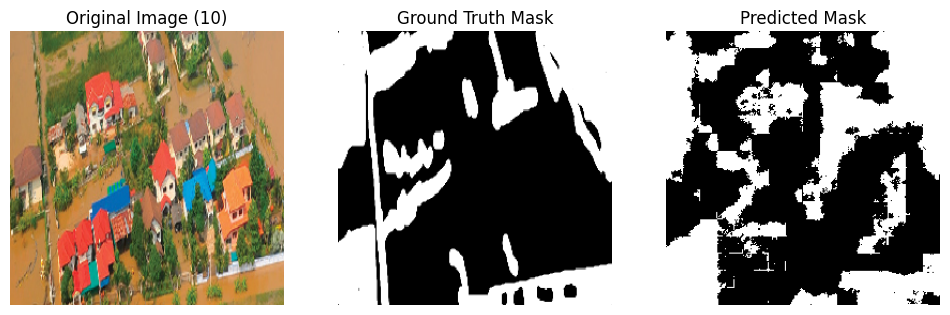

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def visualize_random_prediction(test_generator, pred_masks):
    idx = random.randint(0, len(test_generator) - 1)

    test_image, test_mask = test_generator[idx] 

    
    test_image = test_image[0]  
    test_mask = test_mask[0].squeeze() 
    pred_mask = pred_masks[idx].squeeze()  

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title(f"Original Image ({idx})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(test_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Call the function
visualize_random_prediction(test_generator, pred_masks)